Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import priceForecast

# Numerical solution

In [2]:
from priceForecast import InvestorForecast
model = InvestorForecast()
par = model.par
np.random.seed(2000)
state = np.random.get_state()

Economy's starting parameters

In [3]:
# Initiale betingelser fra datasæt
P_prev = 13017.59
gamma_prev = 0.0211

# Egne intiale betingelser
nF_ini_default = 0.5
q_prev_default = 0.5

# Initiale fordelinger til simulation
nF_vals = [0.25, 0.5, 0.75]
q_vals = [0.178, 0.447, 0.675]

# Stød til prisen gennem log-afkast
gamma_shock_pos = 0.125
P_posShock = P_prev * np.exp(gamma_shock_pos)

gamma_shock_neg = -0.125
P_negShock = P_prev * np.exp(gamma_shock_neg)

# Forecast positivt chok

Ex post q_t

In [4]:
q_expost_t_pos = model.update_q(gamma_prev, gamma_shock_pos, q_prev_default)
print(q_expost_t_pos)

0.43860908535402443


Simulation efter positivt stød

In [5]:
T = 6
result_pos = model.run(P_posShock, gamma_shock_pos, T, nF_ini_default, q_expost_t_pos)

## Resultattabel og diagram for én værdi

In [6]:
print("Periode |    P    |  gamma  |  nF  |  nC  | nNeg | nPos")
print("--------------------------------------------------------")

# Første række: startpris
print(f"{'t-1':>7} | {P_prev:>7.2f} | {'':>7} | {'':>6} | {'':>4} | {'':>5} | {'':>5}")

# Andet punkt: stødpris
print(f"{'t':>7} | {P_posShock:>7.2f} | {gamma_shock_pos:>7.4f} | {'':>6} | {'':>4} | {'':>5} | {'':>5}")

# Simulationens perioder
for t in range(T):
    print(f"{'t+'+str(t+1):>7} | {result_pos['P'][t]:>7.2f} | {result_pos['gamma'][t]:>7.4f} | "
          f"{result_pos['nF'][t]:>6.6f} | {result_pos['nC'][t]:>4.6f} | "
          f"{result_pos['nNeg'][t]:>5.6f} | {result_pos['nPos'][t]:>5.6f}")

Periode |    P    |  gamma  |  nF  |  nC  | nNeg | nPos
--------------------------------------------------------
    t-1 | 13017.59 |         |        |      |       |      
      t | 14750.86 |  0.1250 |        |      |       |      
    t+1 | 14826.65 |  0.0051 | 0.500000 | 0.500000 | 0.264324 | 0.235676
    t+2 | 14871.10 |  0.0030 | 0.494976 | 0.505024 | 0.266298 | 0.238725
    t+3 | 14915.18 |  0.0030 | 0.497165 | 0.502835 | 0.265245 | 0.237591
    t+4 | 14959.40 |  0.0030 | 0.497197 | 0.502803 | 0.265213 | 0.237590
    t+5 | 15003.74 |  0.0030 | 0.497197 | 0.502803 | 0.265215 | 0.237588
    t+6 | 15048.22 |  0.0030 | 0.497197 | 0.502803 | 0.265215 | 0.237588


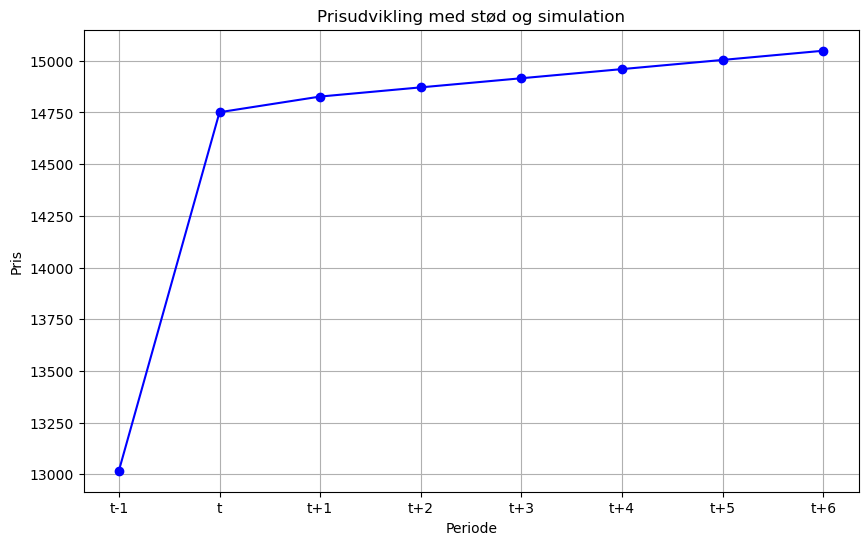

In [7]:
P_all = np.concatenate(([P_prev, P_posShock], result_pos['P']))

# Lav x-akse fra t-1 til t+T
T_total = len(P_all)
perioder = np.arange(T_total)  # 0, 1, 2, ... bruges til positionsindeks

# Lav labels: t-1, t, t+1, ...
labels = ['t-1'] + [f't+{i}' if i>0 else 't' for i in range(T_total-1)]

# Plot
plt.figure(figsize=(10,6))
plt.plot(perioder, P_all, marker='o', linestyle='-', color='blue')
plt.title("Prisudvikling med stød og simulation")
plt.xlabel("Periode")
plt.ylabel("Pris")
plt.xticks(perioder, labels)
plt.grid(True)
plt.show()

## Forskellige initiale værdier

In [8]:
sim_results_pos = {}

for nF_ini in nF_vals:
    for q_prev in q_vals:

        # korrekt ex-post q_t for hvert sæt
        q_expost = model.update_q(gamma_prev, gamma_shock_pos, q_prev)

        key = f"nF={nF_ini}_qPrev={q_prev}"

        result = model.run(
            P_init   = P_posShock,           # pris efter stød
            gamma_init = gamma_shock_pos,    # gamma_t efter stød
            T        = T,
            nF_ini   = nF_ini,
            q_start  = q_expost              # ex-post q_t
        )

        sim_results_pos[key] = result

print("Alle simulationer gennemført.")

Alle simulationer gennemført.


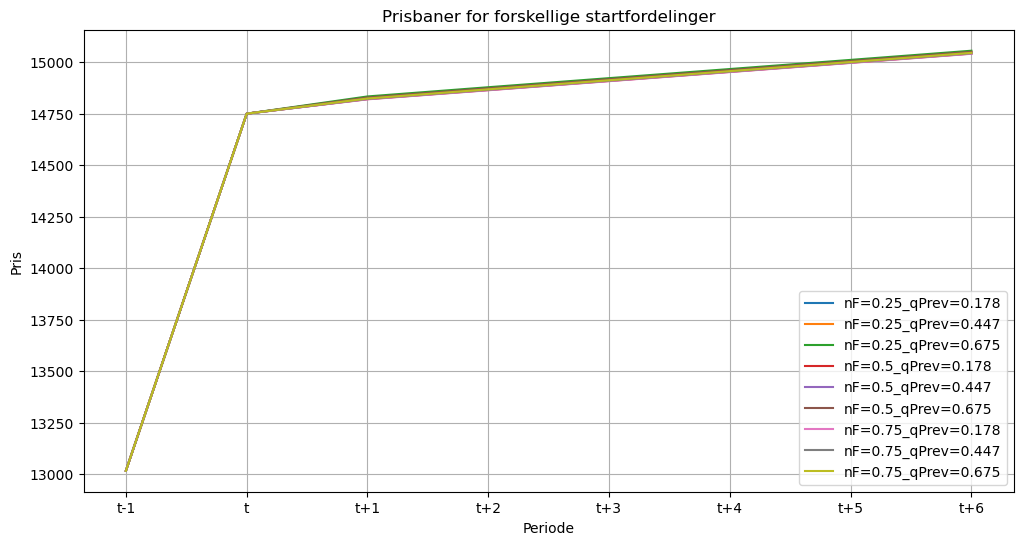

In [9]:
plt.figure(figsize=(12,6))

for key, result in sim_results_pos.items():
    P_all = np.concatenate(([P_prev, P_posShock], result['P']))
    perioder = np.arange(-1, T+1)
    plt.plot(perioder, P_all, label=key)

plt.xlabel("Periode")
plt.ylabel("Pris")
plt.title("Prisbaner for forskellige startfordelinger")
plt.legend()
plt.xticks(perioder, labels)
plt.grid(True)
plt.show()

In [10]:
rows = []

for key, result in sim_results_pos.items():
    nF_val, q_prev_val = [float(s.split('=')[1]) for s in key.split('_')]

    # priser og gamma
    P_all = [P_prev, P_posShock] + list(result['P'])
    gamma_all = [None, gamma_shock_pos] + list(result['gamma'])

    # ex-post q
    q_expost_initial = model.update_q(gamma_prev, gamma_shock_pos, q_prev_val)
    q_expost_all = [q_expost_initial] + list(result['q'])

    # ex-ante q
    q_exante_all = [None] + [model.ex_ante_prob_1(q) for q in q_expost_all]

    # fordelinger skal starte ved modelens output:
    # result['nF'][0] = periode t+1
    nF_all  = [None, None] + list(result["nF"])
    nC_all  = [None, None] + list(result["nC"])
    nNeg_all = [None, None] + list(result["nNeg"])
    nPos_all = [None, None] + list(result["nPos"])

    row = {
        "nF_ini": nF_val,
        "q_prev": q_prev_val
    }

    # priser
    for t, P_t in enumerate(P_all):
        row[f"P{t}"] = int(round(P_t))

    # gamma
    for t, g_t in enumerate(gamma_all):
        row[f"gamma{t}"] = round(g_t, 4) if g_t is not None else None

    # ex-post q
    for t, q_post in enumerate(q_expost_all):
        row[f"q_expost{t+1}"] = round(q_post, 4)

    # ex-ante q
    for t, q_a in enumerate(q_exante_all):
        row[f"q_exante{t+1}"] = round(q_a, 4) if q_a is not None else None

    # fordelinger
    for t, val in enumerate(nF_all):
        row[f"nF{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nC_all):
        row[f"nC{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nNeg_all):
        row[f"nNeg{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nPos_all):
        row[f"nPos{t}"] = round(val, 6) if val is not None else None

    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
print(df)

   nF_ini  q_prev     P0     P1     P2     P3     P4     P5     P6     P7  \
0  0.2500  0.1780  13018  14751  14822  14866  14910  14955  14999  15043   
1  0.2500  0.4470  13018  14751  14829  14873  14917  14962  15006  15051   
2  0.2500  0.6750  13018  14751  14834  14879  14923  14968  15012  15056   
3  0.5000  0.1780  13018  14751  14821  14865  14910  14954  14998  15042   
4  0.5000  0.4470  13018  14751  14826  14870  14914  14958  15003  15047   
5  0.5000  0.6750  13018  14751  14829  14874  14918  14962  15007  15051   
6  0.7500  0.1780  13018  14751  14820  14864  14909  14953  14997  15042   
7  0.7500  0.4470  13018  14751  14823  14867  14911  14955  15000  15044   
8  0.7500  0.6750  13018  14751  14824  14869  14913  14957  15002  15046   

  gamma0  gamma1  gamma2  gamma3  gamma4  gamma5  gamma6  gamma7  q_expost1  \
0   None  0.1250  0.0048  0.0030  0.0030  0.0030  0.0030  0.0030     0.4867   
1   None  0.1250  0.0053  0.0030  0.0030  0.0030  0.0030  0.0030     0.

# Forecast negativt chok

Ex post q_t

In [11]:
q_expost_t_neg = model.update_q(gamma_prev, gamma_shock_neg, q_prev_default)
print(q_expost_t_neg)

0.6980007920512686


Simulation efter engativt stød

In [12]:
T = 6
result_neg = model.run(P_negShock, gamma_shock_neg, T, nF_ini_default, q_expost_t_neg)

## Resultattabel og diagram for én værdi

In [13]:
print("Periode |    P    |  gamma  |  nF  |  nC  | nNeg | nPos")
print("--------------------------------------------------------")

# Første række: startpris
print(f"{'t-1':>7} | {P_prev:>7.2f} | {'':>7} | {'':>6} | {'':>4} | {'':>5} | {'':>5}")

# Andet punkt: stødpris
print(f"{'t':>7} | {P_negShock:>7.2f} | {gamma_shock_neg:>7.4f} | {'':>6} | {'':>4} | {'':>5} | {'':>5}")

# Simulationens perioder
for t in range(T):
    print(f"{'t+'+str(t+1):>7} | {result_neg['P'][t]:>7.2f} | {result_neg['gamma'][t]:>7.4f} | "
          f"{result_neg['nF'][t]:>6.6f} | {result_neg['nC'][t]:>4.6f} | "
          f"{result_neg['nNeg'][t]:>5.6f} | {result_neg['nPos'][t]:>5.6f}")

Periode |    P    |  gamma  |  nF  |  nC  | nNeg | nPos
--------------------------------------------------------
    t-1 | 13017.59 |         |        |      |       |      
      t | 11487.98 | -0.1250 |        |      |       |      
    t+1 | 11537.90 |  0.0043 | 0.500000 | 0.500000 | 0.244999 | 0.255001
    t+2 | 11578.70 |  0.0035 | 0.495906 | 0.504094 | 0.252190 | 0.251904
    t+3 | 11612.16 |  0.0029 | 0.496640 | 0.503360 | 0.267513 | 0.235847
    t+4 | 11646.71 |  0.0030 | 0.497270 | 0.502730 | 0.264880 | 0.237850
    t+5 | 11681.22 |  0.0030 | 0.497186 | 0.502814 | 0.265264 | 0.237550
    t+6 | 11715.85 |  0.0030 | 0.497199 | 0.502801 | 0.265207 | 0.237594


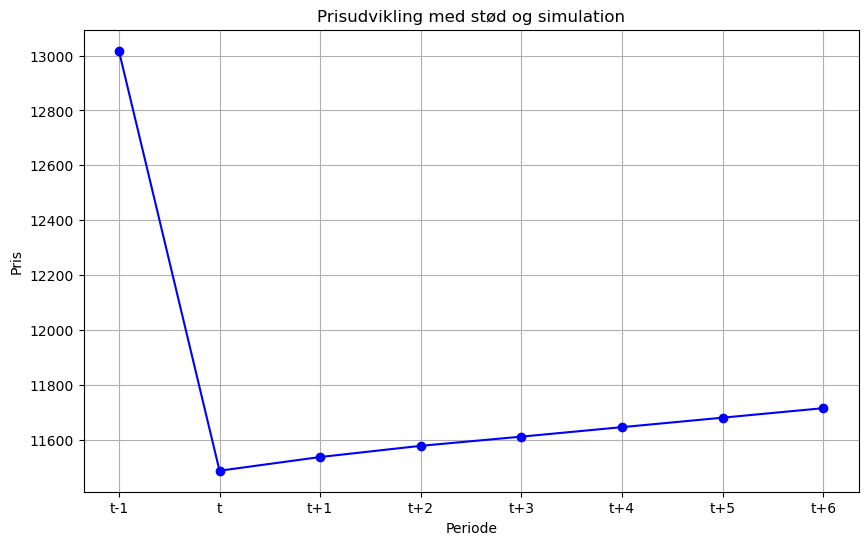

In [14]:
P_all = np.concatenate(([P_prev, P_negShock], result_neg['P']))

# Lav x-akse fra t-1 til t+T
T_total = len(P_all)
perioder = np.arange(T_total)  # 0, 1, 2, ... bruges til positionsindeks

# Lav labels: t-1, t, t+1, ...
labels = ['t-1'] + [f't+{i}' if i>0 else 't' for i in range(T_total-1)]

# Plot
plt.figure(figsize=(10,6))
plt.plot(perioder, P_all, marker='o', linestyle='-', color='blue')
plt.title("Prisudvikling med stød og simulation")
plt.xlabel("Periode")
plt.ylabel("Pris")
plt.xticks(perioder, labels)
plt.grid(True)
plt.show()

## Forskellige initiale værdier

In [15]:
sim_results_neg = {}

for nF_ini in nF_vals:
    for q_prev in q_vals:

        # korrekt ex-post q_t for hvert sæt
        q_expost = model.update_q(gamma_prev, gamma_shock_neg, q_prev)

        key = f"nF={nF_ini}_qPrev={q_prev}"

        result = model.run(
            P_init   = P_negShock,           # pris efter stød
            gamma_init = gamma_shock_neg,    # gamma_t efter stød
            T        = T,
            nF_ini   = nF_ini,
            q_start  = q_expost              # ex-post q_t
        )

        sim_results_neg[key] = result

print("Alle simulationer gennemført.")

Alle simulationer gennemført.


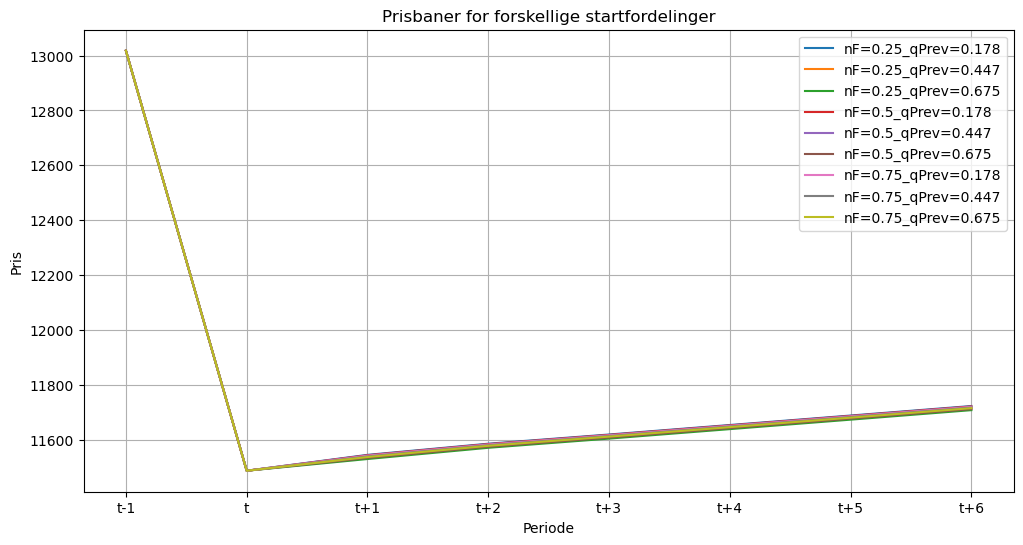

In [16]:
plt.figure(figsize=(12,6))

for key, result in sim_results_neg.items():
    P_all = np.concatenate(([P_prev, P_negShock], result['P']))
    perioder = np.arange(-1, T+1)
    plt.plot(perioder, P_all, label=key)


plt.xlabel("Periode")
plt.ylabel("Pris")
plt.title("Prisbaner for forskellige startfordelinger")
plt.xticks(perioder, labels)
plt.legend()
plt.grid(True)
plt.show()

In [17]:
rows = []

for key, result in sim_results_neg.items():
    nF_val, q_prev_val = [float(s.split('=')[1]) for s in key.split('_')]

    # priser og gamma
    P_all = [P_prev, P_negShock] + list(result['P'])
    gamma_all = [None, gamma_shock_neg] + list(result['gamma'])

    # ex-post q
    q_expost_initial = model.update_q(gamma_prev, gamma_shock_neg, q_prev_val)
    q_expost_all = [q_expost_initial] + list(result['q'])

    # ex-ante q
    q_exante_all = [None] + [model.ex_ante_prob_1(q) for q in q_expost_all]

    # fordelinger skal starte ved modelens output:
    # result['nF'][0] = periode t+1
    nF_all  = [None, None] + list(result["nF"])
    nC_all  = [None, None] + list(result["nC"])
    nNeg_all = [None, None] + list(result["nNeg"])
    nPos_all = [None, None] + list(result["nPos"])

    row = {
        "nF_ini": nF_val,
        "q_prev": q_prev_val
    }

    # priser
    for t, P_t in enumerate(P_all):
        row[f"P{t}"] = int(round(P_t))

    # gamma
    for t, g_t in enumerate(gamma_all):
        row[f"gamma{t}"] = round(g_t, 4) if g_t is not None else None

    # ex-post q
    for t, q_post in enumerate(q_expost_all):
        row[f"q_expost{t+1}"] = round(q_post, 4)

    # ex-ante q
    for t, q_a in enumerate(q_exante_all):
        row[f"q_exante{t+1}"] = round(q_a, 4) if q_a is not None else None

    # fordelinger
    for t, val in enumerate(nF_all):
        row[f"nF{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nC_all):
        row[f"nC{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nNeg_all):
        row[f"nNeg{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nPos_all):
        row[f"nPos{t}"] = round(val, 6) if val is not None else None

    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
print(df)

   nF_ini  q_prev     P0     P1     P2     P3     P4     P5     P6     P7  \
0  0.2500  0.1780  13018  11488  11546  11586  11620  11654  11689  11724   
1  0.2500  0.4470  13018  11488  11538  11579  11612  11647  11681  11716   
2  0.2500  0.6750  13018  11488  11531  11572  11605  11639  11674  11709   
3  0.5000  0.1780  13018  11488  11544  11585  11618  11653  11688  11722   
4  0.5000  0.4470  13018  11488  11539  11580  11613  11648  11682  11717   
5  0.5000  0.6750  13018  11488  11534  11575  11609  11643  11678  11712   
6  0.7500  0.1780  13018  11488  11543  11583  11617  11652  11686  11721   
7  0.7500  0.4470  13018  11488  11540  11581  11614  11649  11684  11718   
8  0.7500  0.6750  13018  11488  11538  11579  11612  11647  11681  11716   

  gamma0  gamma1  gamma2  gamma3  gamma4  gamma5  gamma6  gamma7  q_expost1  \
0   None -0.1250  0.0050  0.0035  0.0029  0.0030  0.0030  0.0030     0.7372   
1   None -0.1250  0.0043  0.0035  0.0029  0.0030  0.0030  0.0030     0.

## Risikoaversion

Alle simulationer gennemført.


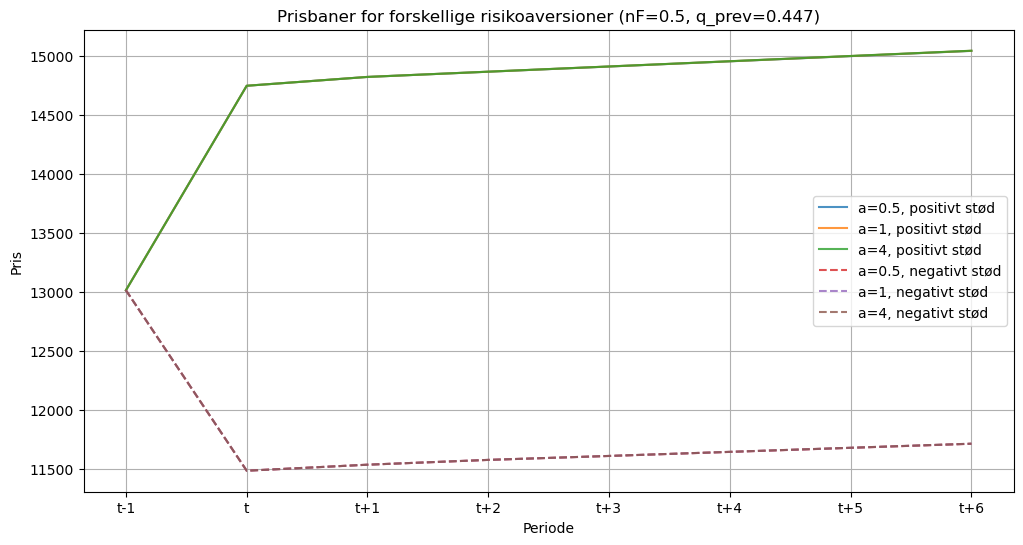

In [18]:
a_values = [0.5, 1, 4]
nF_ini = 0.5
q_prev = 0.447

sim_results_pos_a = {}
sim_results_neg_a = {}

# Kør simulationer for forskellige a, men faste nF og q_prev
for a in a_values:
    par.a = a  # sæt risikoaversionen

    # Positivt stød
    q_expost = model.update_q(gamma_prev, gamma_shock_pos, q_prev)
    key = f"a={a}"
    result = model.run(
        P_init = P_posShock,
        gamma_init = gamma_shock_pos,
        T = T,
        nF_ini = nF_ini,
        q_start = q_expost
    )
    sim_results_pos_a[key] = result

    # Negativt stød
    q_expost = model.update_q(gamma_prev, gamma_shock_neg, q_prev)
    result = model.run(
        P_init = P_negShock,
        gamma_init = gamma_shock_neg,
        T = T,
        nF_ini = nF_ini,
        q_start = q_expost
    )
    sim_results_neg_a[key] = result

print("Alle simulationer gennemført.")

# Plot prisbaner for positive og negative stød
plt.figure(figsize=(12,6))
perioder = np.arange(-1, T+1)

for key, result in sim_results_pos_a.items():
    P_all = np.concatenate(([P_prev, P_posShock], result['P']))
    plt.plot(perioder, P_all, linestyle='-', alpha=0.8, label=f"{key}, positivt stød")

for key, result in sim_results_neg_a.items():
    P_all = np.concatenate(([P_prev, P_negShock], result['P']))
    plt.plot(perioder, P_all, linestyle='--', alpha=0.8, label=f"{key}, negativt stød")

plt.xlabel("Periode")
plt.ylabel("Pris")
plt.title("Prisbaner for forskellige risikoaversioner (nF=0.5, q_prev=0.447)")
plt.grid(True)
plt.legend()
plt.xticks(perioder, labels)
plt.show()

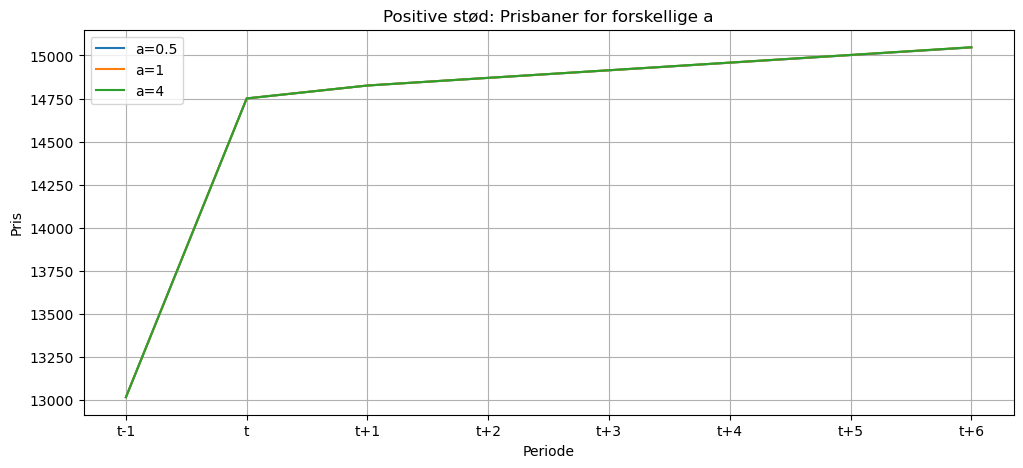

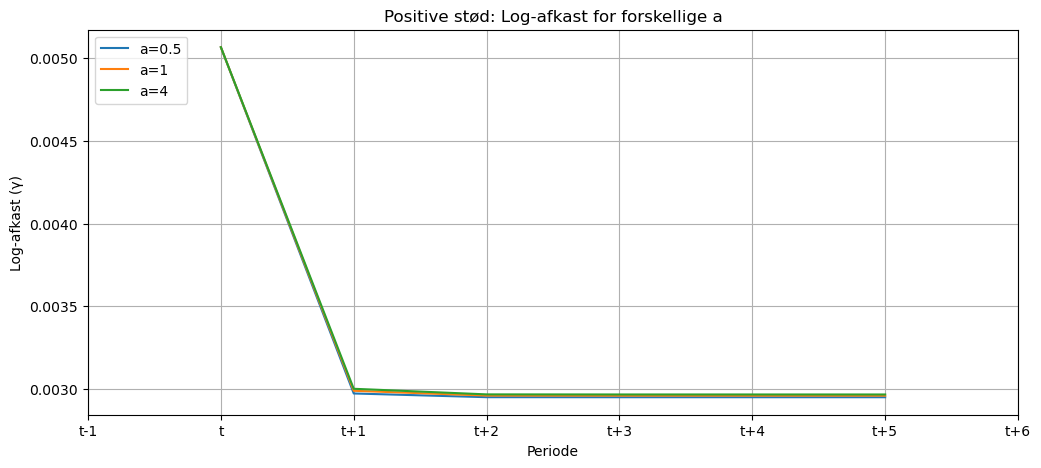

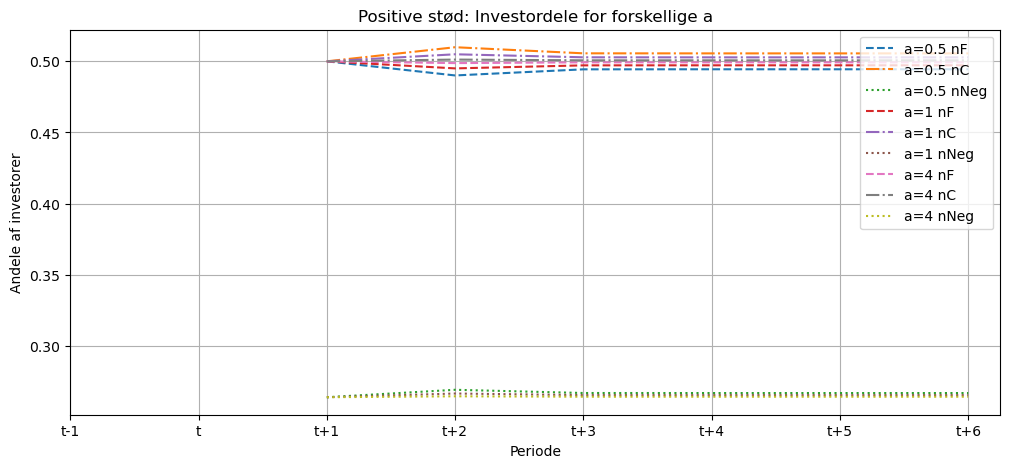

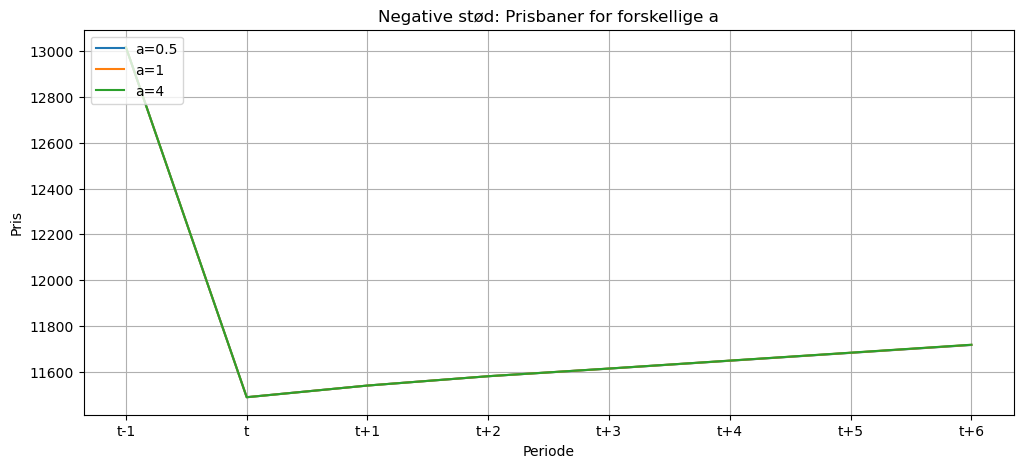

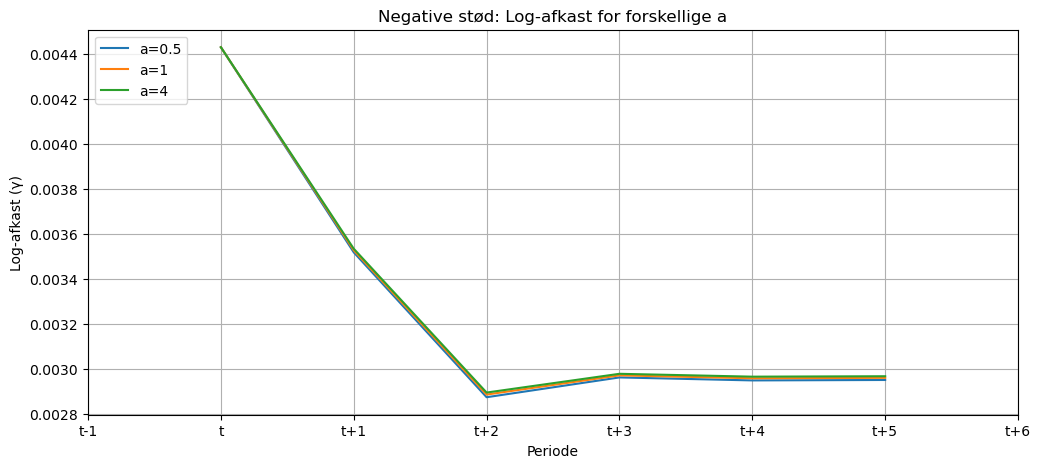

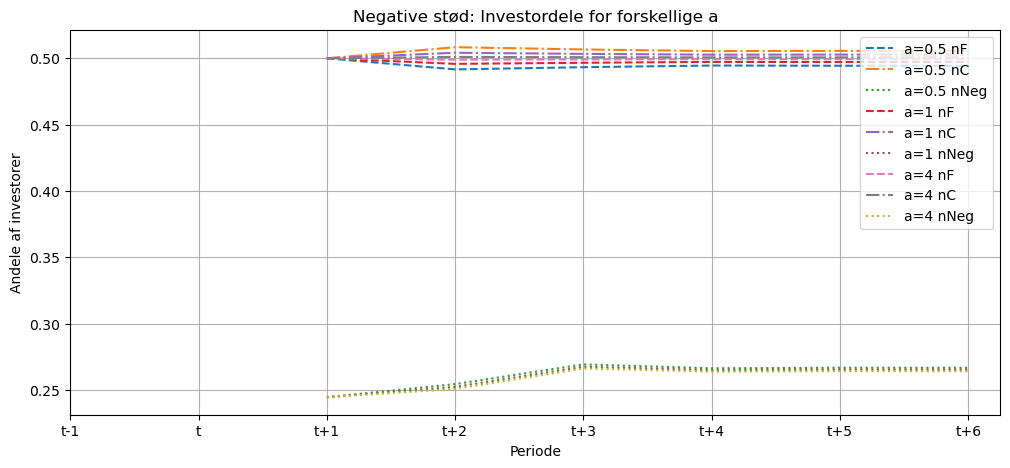

In [19]:
def plot_results_a(sim_results, P_prev, P_shock, title_prefix):
    """
    Plotter pris, log-afkast og investordele for simulationer, kun med varierende a.
    Returnerer samtidig højeste og laveste pris over alle simulationer.
    """
    max_price = -np.inf
    min_price = np.inf
    
    plt.figure(figsize=(12,5))
    
    for key, result in sim_results.items():
        # Pris
        P_all = np.concatenate(([P_prev, P_shock], result['P']))
        plt.plot(range(-1, len(P_all)-1), P_all, label=key)
        
        # Track min/max pris
        max_price = max(max_price, max(P_all))
        min_price = min(min_price, min(P_all))
        
    plt.xlabel("Periode")
    plt.ylabel("Pris")
    plt.title(f"{title_prefix}: Prisbaner for forskellige a")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(perioder, labels)
    plt.show()
    
    # Log-afkast
    plt.figure(figsize=(12,5))
    for key, result in sim_results.items():
        gamma_all = np.concatenate(([None, result['gamma'][0]], result['gamma'][1:]))
        plt.plot(range(-1, len(gamma_all)-1), gamma_all, label=key)
    plt.xlabel("Periode")
    plt.ylabel("Log-afkast (γ)")
    plt.title(f"{title_prefix}: Log-afkast for forskellige a")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(perioder, labels)
    plt.show()
    
    
    # Investordele
    plt.figure(figsize=(12,5))
    for key, result in sim_results.items():
        nF_all = np.concatenate(([None, None], result['nF']))
        nC_all = np.concatenate(([None, None], result['nC']))
        nNeg_all = np.concatenate(([None, None], result['nNeg']))
        plt.plot(range(-1, len(nF_all)-1), nF_all, '--', label=f"{key} nF")
        plt.plot(range(-1, len(nC_all)-1), nC_all, '-.', label=f"{key} nC")
        plt.plot(range(-1, len(nNeg_all)-1), nNeg_all, ':', label=f"{key} nNeg")
    plt.xlabel("Periode")
    plt.ylabel("Andele af investorer")
    plt.title(f"{title_prefix}: Investordele for forskellige a")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=10)
    plt.xticks(perioder, labels)
    plt.show()
    
    
    return min_price, max_price

# Plot resultater kun for varierende a
min_pos_a, max_pos_a = plot_results_a(sim_results_pos_a, P_prev, P_posShock, "Positive stød")
min_neg_a, max_neg_a = plot_results_a(sim_results_neg_a, P_prev, P_negShock, "Negative stød")


In [20]:
# Funktion til at finde min/max pris i sidste periode for simulationer, kun med varierende a
def final_period_price_range_a(sim_results):
    final_prices = []
    for key, result in sim_results.items():
        # Sidste pris i simulationen
        final_prices.append(result['P'][-1])
    return min(final_prices), max(final_prices)

# Positive stød, kun varierende a
min_final_pos_a, max_final_pos_a = final_period_price_range_a(sim_results_pos_a)

# Negative stød, kun varierende a
min_final_neg_a, max_final_neg_a = final_period_price_range_a(sim_results_neg_a)

print(f"Positive stød - sidste periode: laveste pris = {min_final_pos_a:.3f}, højeste pris = {max_final_pos_a:.3f}")
print(f"Negative stød - sidste periode: laveste pris = {min_final_neg_a:.3f}, højeste pris = {max_final_neg_a:.3f}")

Positive stød - sidste periode: laveste pris = 15046.474, højeste pris = 15047.906
Negative stød - sidste periode: laveste pris = 11716.345, højeste pris = 11717.356


In [21]:
rows_pos = []

for key, result in sim_results_pos_a.items():
    # udtræk a-værdien fra key
    a_val = float(key.split('_')[0].split('=')[1])

    # priser og gamma
    P_all = [P_prev, P_posShock] + list(result['P'])
    gamma_all = [None, gamma_shock_pos] + list(result['gamma'])

    # ex-post q
    q_expost_initial = model.update_q(gamma_prev, gamma_shock_pos, 0.447)  # fast q_prev
    q_expost_all = [q_expost_initial] + list(result['q'])

    # ex-ante q
    q_exante_all = [None] + [model.ex_ante_prob_1(q) for q in q_expost_all]

    # fordelinger
    nF_all  = [None, None] + list(result["nF"])
    nC_all  = [None, None] + list(result["nC"])
    nNeg_all = [None, None] + list(result["nNeg"])
    nPos_all = [None, None] + list(result["nPos"])

    row = {
        "a": a_val,
        "nF_ini": 0.5,
        "q_prev": 0.447
    }

    # priser
    for t, P_t in enumerate(P_all):
        row[f"P{t}"] = int(round(P_t))

    # gamma
    for t, g_t in enumerate(gamma_all):
        row[f"gamma{t}"] = round(g_t, 4) if g_t is not None else None

    # ex-post q
    for t, q_post in enumerate(q_expost_all):
        row[f"q_expost{t+1}"] = round(q_post, 4)

    # ex-ante q
    for t, q_a in enumerate(q_exante_all):
        row[f"q_exante{t+1}"] = round(q_a, 4) if q_a is not None else None

    # fordelinger
    for t, val in enumerate(nF_all):
        row[f"nF{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nC_all):
        row[f"nC{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nNeg_all):
        row[f"nNeg{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nPos_all):
        row[f"nPos{t}"] = round(val, 6) if val is not None else None

    rows_pos.append(row)

df_a_pos = pd.DataFrame(rows_pos)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
print(df_a_pos)

       a  nF_ini  q_prev     P0     P1     P2     P3     P4     P5     P6  \
0 0.5000  0.5000  0.4470  13018  14751  14826  14870  14914  14958  15002   
1 1.0000  0.5000  0.4470  13018  14751  14826  14870  14914  14958  15003   
2 4.0000  0.5000  0.4470  13018  14751  14826  14870  14915  14959  15003   

      P7 gamma0  gamma1  gamma2  gamma3  gamma4  gamma5  gamma6  gamma7  \
0  15046   None  0.1250  0.0051  0.0030  0.0030  0.0030  0.0030  0.0030   
1  15047   None  0.1250  0.0051  0.0030  0.0030  0.0030  0.0030  0.0030   
2  15048   None  0.1250  0.0051  0.0030  0.0030  0.0030  0.0030  0.0030   

   q_expost1  q_expost2  q_expost3  q_expost4  q_expost5  q_expost6  \
0     0.4464     0.4465     0.4465     0.4465     0.4465     0.4465   
1     0.4464     0.4465     0.4465     0.4465     0.4465     0.4465   
2     0.4464     0.4465     0.4465     0.4465     0.4465     0.4465   

   q_expost7 q_exante1  q_exante2  q_exante3  q_exante4  q_exante5  q_exante6  \
0     0.4465      None  

In [22]:
rows = []

for key, result in sim_results_neg_a.items():
    # udtræk a-værdien fra key
    a_val = float(key.split('_')[0].split('=')[1])

    # priser og gamma
    P_all = [P_prev, P_negShock] + list(result['P'])
    gamma_all = [None, gamma_shock_neg] + list(result['gamma'])

    # ex-post q
    q_expost_initial = model.update_q(gamma_prev, gamma_shock_neg, 0.447)  # fast q_prev
    q_expost_all = [q_expost_initial] + list(result['q'])

    # ex-ante q
    q_exante_all = [None] + [model.ex_ante_prob_1(q) for q in q_expost_all]

    # fordelinger
    nF_all  = [None, None] + list(result["nF"])
    nC_all  = [None, None] + list(result["nC"])
    nNeg_all = [None, None] + list(result["nNeg"])
    nPos_all = [None, None] + list(result["nPos"])

    row = {
        "a": a_val,
        "nF_ini": 0.5,
        "q_prev": 0.447
    }

    # priser
    for t, P_t in enumerate(P_all):
        row[f"P{t}"] = int(round(P_t))

    # gamma
    for t, g_t in enumerate(gamma_all):
        row[f"gamma{t}"] = round(g_t, 4) if g_t is not None else None

    # ex-post q
    for t, q_post in enumerate(q_expost_all):
        row[f"q_expost{t+1}"] = round(q_post, 4)

    # ex-ante q
    for t, q_a in enumerate(q_exante_all):
        row[f"q_exante{t+1}"] = round(q_a, 4) if q_a is not None else None

    # fordelinger
    for t, val in enumerate(nF_all):
        row[f"nF{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nC_all):
        row[f"nC{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nNeg_all):
        row[f"nNeg{t}"] = round(val, 6) if val is not None else None

    for t, val in enumerate(nPos_all):
        row[f"nPos{t}"] = round(val, 6) if val is not None else None

    rows.append(row)

df_a = pd.DataFrame(rows)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
print(df_a)

       a  nF_ini  q_prev     P0     P1     P2     P3     P4     P5     P6  \
0 0.5000  0.5000  0.4470  13018  11488  11539  11580  11613  11647  11682   
1 1.0000  0.5000  0.4470  13018  11488  11539  11580  11613  11648  11682   
2 4.0000  0.5000  0.4470  13018  11488  11539  11580  11613  11648  11683   

      P7 gamma0  gamma1  gamma2  gamma3  gamma4  gamma5  gamma6  gamma7  \
0  11716   None -0.1250  0.0044  0.0035  0.0029  0.0030  0.0029  0.0030   
1  11717   None -0.1250  0.0044  0.0035  0.0029  0.0030  0.0030  0.0030   
2  11717   None -0.1250  0.0044  0.0035  0.0029  0.0030  0.0030  0.0030   

   q_expost1  q_expost2  q_expost3  q_expost4  q_expost5  q_expost6  \
0     0.7046     0.6280     0.4199     0.4504     0.4459     0.4466   
1     0.7046     0.6280     0.4199     0.4504     0.4459     0.4466   
2     0.7046     0.6280     0.4199     0.4504     0.4459     0.4466   

   q_expost7 q_exante1  q_exante2  q_exante3  q_exante4  q_exante5  q_exante6  \
0     0.4465      None  